In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedKFold
sns.set()

from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD


Nuestras libreria:

In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion
from preprocessing import get_dataframe_polynomial
from preprocessing import reduccion_rfecv
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada

# Obtención de datasets, separación holdout

Antes de aplicar el primer preprocesamiento, vamos a agarrar el 5% de nuestro dataset para tenerlo como particion de holdout que lo usaremos a lo ultimo de todo para verificar el score con el mejor preprocesamiento obtenido usando train y test, ademas de cross validation.

In [3]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)

Además para varios preproceasmientos que probaremos usaremos esta funcion que nos calcula el AUC-ROC para test y train, como tambien nos imprime los mejores hiperparametros elegidos.

In [4]:
def auc_roc_for(X, y):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, random_state=10, test_size=0.20, stratify=y_df)

    params = {
        'max_depth': np.arange(2, 6),
        'min_samples_leaf': np.arange(500,800,50),
        "criterion": ["gini", "entropy"],
    }

    cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(XX_train, yy_train)
    clf_r = tree.DecisionTreeClassifier(random_state=10)
    clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

    clf.fit(XX_train, yy_train)
    yy_pred = clf.predict(XX_test)

    print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)
    '''
    print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
    print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
    graficar_matriz_confusion(yy_test, yy_pred)
    plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)
    '''

# Primer Preprocesamiento simple: conversion_numerica()

In [5]:
X_df_numerico = conversion_numerica(X_df) 

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Aplicando 'conversion_numerica' en las variables categóricas.


AUC-ROC score sobre test:  0.8850805931573844
AUC-ROC score sobre train:  0.8843632504444328
Accuracy sobre test:  0.8360202671579917
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      5377
  Alto valor       0.52      0.72      0.61      1136

    accuracy                           0.84      6513
   macro avg       0.73      0.79      0.75      6513
weighted avg       0.86      0.84      0.85      6513



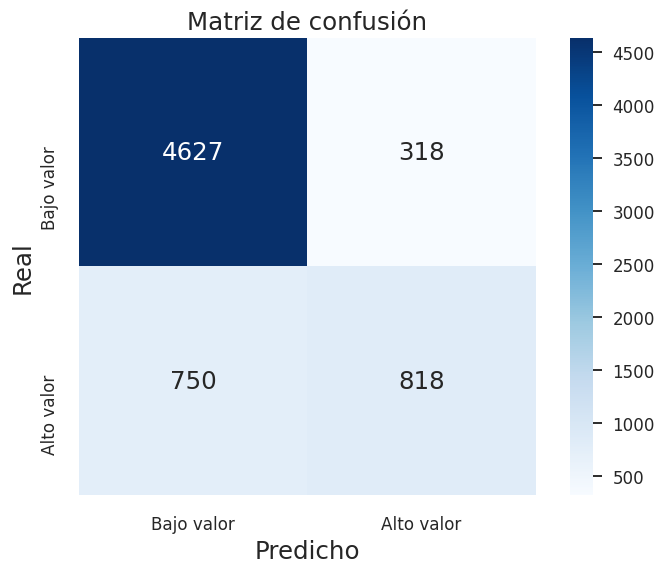

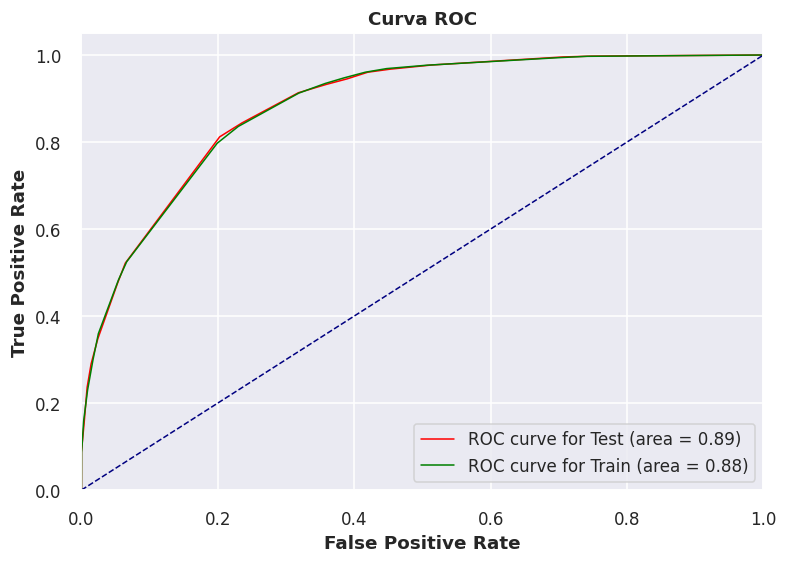

In [6]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_numerico, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropreduccion_rfecvy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(XX_train, yy_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)


# Segundo Preprocesamiento: conversion_numerica_generalizada()

In [7]:
df, df_for_prediction = obtener_datasets()
X_df_2, y_df = aplicar_preparacion_generalizado(df)
X_df_numerico_2 = conversion_numerica_generalizada(X_df_2) 

Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


In [8]:
X_df_numerico_2.shape

(32561, 43)

AUC-ROC score sobre test:  0.8850805931573844
AUC-ROC score sobre train:  0.8843632504444328
Accuracy sobre test:  0.8360202671579917
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      5377
  Alto valor       0.52      0.72      0.61      1136

    accuracy                           0.84      6513
   macro avg       0.73      0.79      0.75      6513
weighted avg       0.86      0.84      0.85      6513



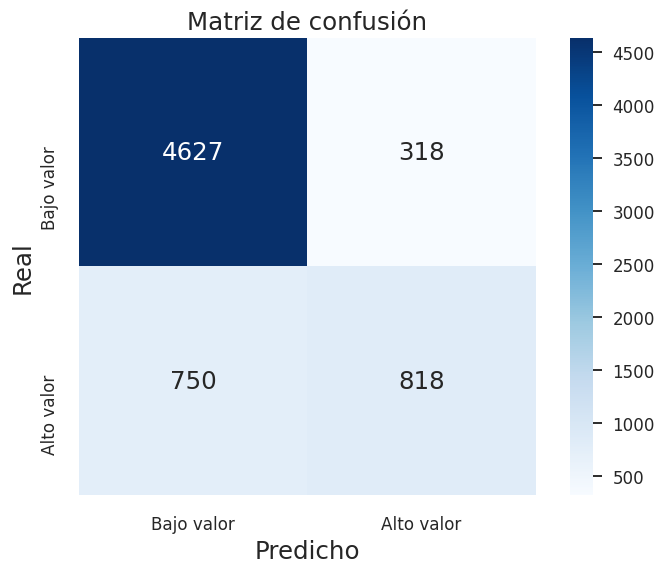

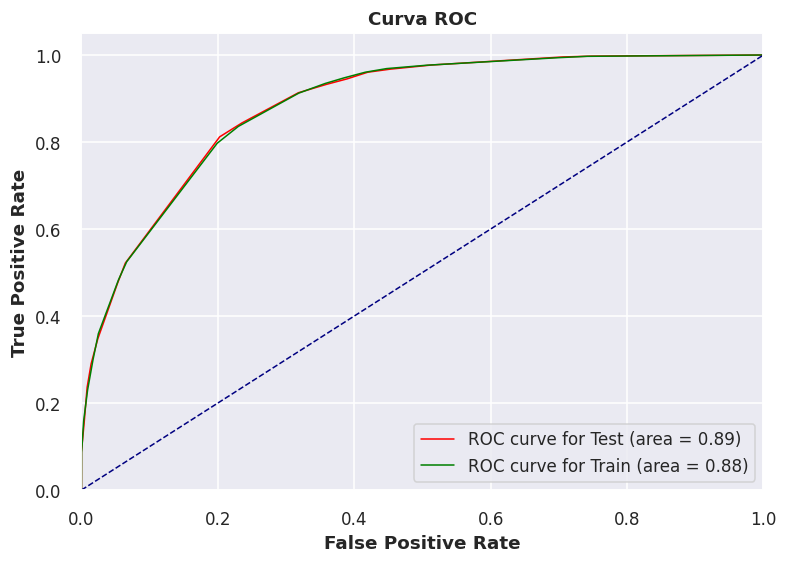

In [9]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_numerico_2, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropreduccion_rfecvy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(XX_train, yy_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)


# Tercer Preprocesamiento: get_dataframe_polynomial()

* Con PolynomialFeatures(2, interaction_only = True)

In [10]:
X_reduced_poly = get_dataframe_polynomial(X_df_numerico, 2, True)
X_reduced_poly.shape

Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 46 features...


(32561, 46)

In [11]:
auc_roc_for(X_reduced_poly, y_df)

AUC-ROC score sobre test:  0.8799096825282186
AUC-ROC score sobre train:  0.8850861970804582
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}


* Con PolynomialFeatures(2, interaction_only = False)

In [12]:
X_reduced_poly = get_dataframe_polynomial(X_df_numerico, 2, False)
X_reduced_poly.shape

Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 50 features...


(32561, 50)

In [13]:
auc_roc_for(X_reduced_poly, y_df)

AUC-ROC score sobre test:  0.8875250201192711
AUC-ROC score sobre train:  0.8923402505832897
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}


# Cuarto Preprocesamiento: reduccion_rfecv()

Aplicando 'conversion_numerica' en las variables categóricas.
AUC-ROC score sobre test:  0.8830865283423786
AUC-ROC score sobre train:  0.8830260968334380
Accuracy sobre test:  0.8360202671579917
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 500}
              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      5377
  Alto valor       0.52      0.72      0.61      1136

    accuracy                           0.84      6513
   macro avg       0.73      0.79      0.75      6513
weighted avg       0.86      0.84      0.85      6513



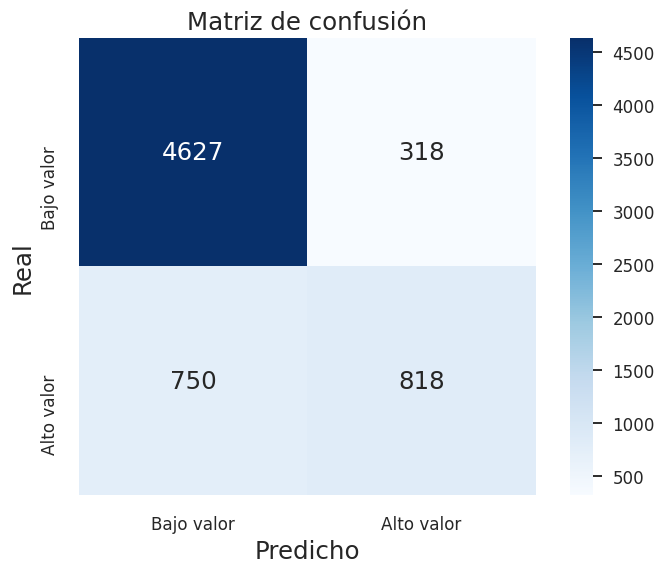

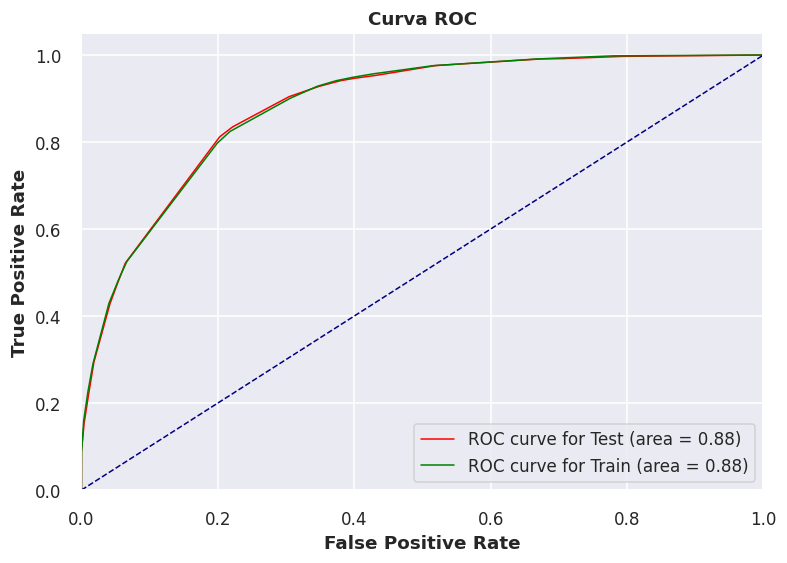

In [14]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

clf = tree.DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 5, min_samples_leaf =500)
X_reducido = reduccion_rfecv(
    estimator=clf,
    X_df = X_df_numerico,
    y_df = y_df,
    min_features_to_select=5,
    step=5,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5
)
XX_train, XX_test, yy_train, yy_test = train_test_split(X_reducido, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropreduccion_rfecvy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(XX_train, yy_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)


# Quinto Preprocesamiento: reduccion_rfecv() + get_dataframe_polynomial()

In [15]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

clf = tree.DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 5, min_samples_leaf =500)
X_reducido = reduccion_rfecv(
    estimator=clf,
    X_df = X_df_numerico,
    y_df = y_df,
    min_features_to_select=10,
    step=5,
    n_jobs=-1,
    scoring="roc_auc",
    cv=5
)

Aplicando 'conversion_numerica' en las variables categóricas.


* Con PolynomialFeatures(2, interaction_only = True)

In [16]:
X_reduced_poly = get_dataframe_polynomial(X_reducido, 2, True)
X_reduced_poly.shape

Dataset inicial con 10 features...
Dataset nuevo con PolynomialFeature con 16 features...


(32561, 16)

In [17]:
auc_roc_for(X_reduced_poly, y_df)

AUC-ROC score sobre test:  0.8780838586698582
AUC-ROC score sobre train:  0.8847249394037779
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}


* Con PolynomialFeatures(2, interaction_only = False)

In [18]:
X_reduced_poly = get_dataframe_polynomial(X_reducido, 2, False)
X_reduced_poly.shape

Dataset inicial con 10 features...
Dataset nuevo con PolynomialFeature con 20 features...


(32561, 20)

In [19]:
auc_roc_for(X_reduced_poly, y_df)

AUC-ROC score sobre test:  0.8874141061884814
AUC-ROC score sobre train:  0.8922651711234894
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}


# El mejor: get_dataframe_polynomial()

In [20]:
X_reduced_poly = get_dataframe_polynomial(X_df_numerico, 2, False)
X_reduced_poly.shape

Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 50 features...


(32561, 50)

AUC-ROC score sobre test:  0.8875250201192711
AUC-ROC score sobre train:  0.8923402505832897
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}
Accuracy sobre test:  0.8363273453093812
              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      5377
  Alto valor       0.52      0.72      0.61      1136

    accuracy                           0.84      6513
   macro avg       0.73      0.79      0.75      6513
weighted avg       0.86      0.84      0.85      6513



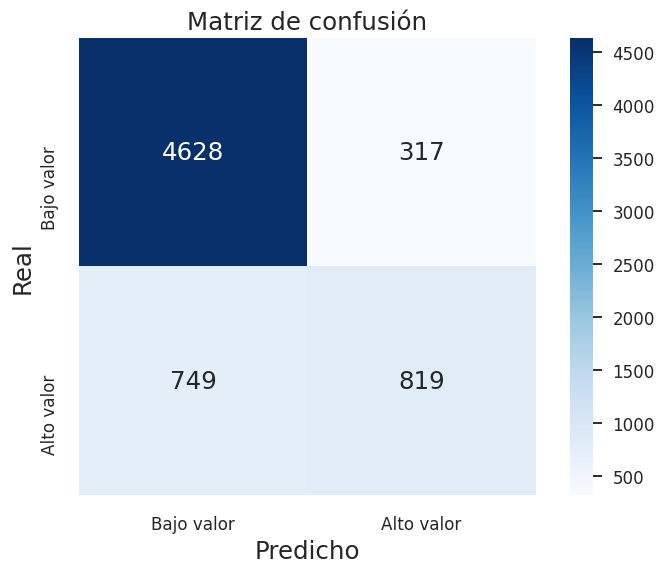

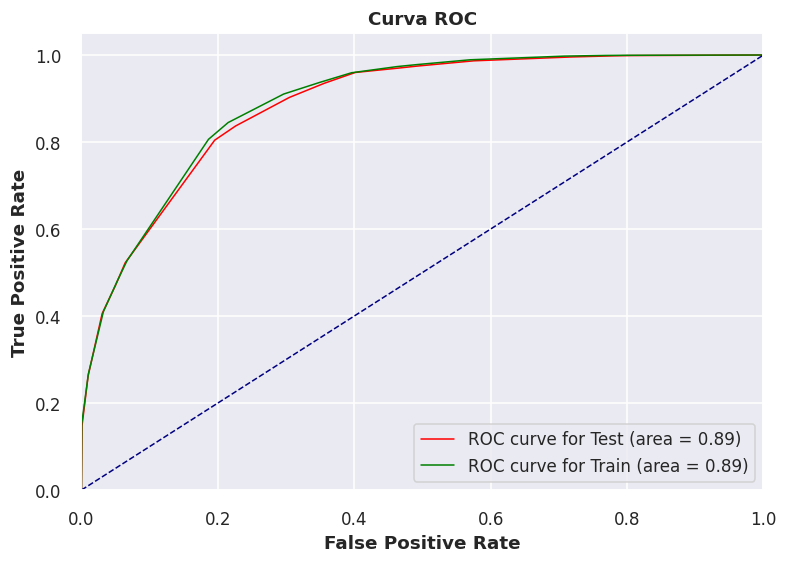

In [21]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_reduced_poly, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(2, 6),
    'min_samples_leaf': np.arange(500,800,50),
    "criterion": ["gini", "entropy"],
}

cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(XX_train, yy_train)
clf_r = tree.DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(yy_pred, yy_test))
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(yy_test, yy_pred)
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)
